In [1]:
from neurodiffeq import diff
from neurodiffeq.networks import FCNN
from neurodiffeq.pde import solve2D, ExampleGenerator2D, Monitor2D
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

# Homogeneous Neumann B.C on a Circular Boundary

If we want to include both Dirichlet B.C and Neumann B.C. on arbitrarily-shaped boundaries, the trial solution will look more complex. In the following equation:

* $g(\vec{x})$ is $g(\vec{x})$ in $\hat n(\vec{x}) \cdot \nabla u = g(\vec{x})$, where $\hat n(\vec{x})$ is the normal vector at $\vec{x}$
* $L_D(\vec{x})$ indicates how far away is $\vec{x}$ from the Dirichlet booundary condition, $L_D(\vec{x}) = 0$ on Dirichlet boundary. 
* $L_M(\vec{x})$ indicates how far away is $\vec{x}$ from the Neumann booundary condition, $L_D(\vec{x}) = 0$ on Neumann boundary. 
* $N$ is the output of the neural net
* $x_k$ is the $k-th$ dimension of $\vec{x}$
* $n_k$ is the $k-th$ dimension of the normal vector at $\vec{x}$ (on Neumann boundary, but should also be defined outside the Neumann boundary so that out trial solution can be evaluated outside the Neumann boundary as well)
* $F$ is $L_D(\vec{x})N$
* The $K(1-e^{1-L_M(\vec{x})})$ is for avoiding division by zero.

![](imgs/neumann_bc.png)

For a circular Neumann boundary on the circle $||\vec{x}||^2 = r^2$, the above trial solution can be simplified because:

* $L_D(\vec{x})$ is just 1 every where and $A_D(\vec)$ doesn't matter. (There is not Dirichlet boundary)
* $L_M(\vec{x})$ is just $r^2 - ||\vec{x}||^2$
* $\hat n(\vec{x})$ is just $\frac{1}{r} \vec{x}$

Unfortunately, I haven't get this part working yet...

In [2]:
def _nn_output(net, xyz_etc, ith):
    original_shape  = xyz_etc[0].shape
    xyz_etc = torch.cat(xyz_etc, 1)
    output = net(xyz_etc)
    return output[:, ith].reshape(original_shape)

In [3]:
class CircularNeumannHomogeneous:
    
    def __init__(self, r, val=0.0, ith=0, K=5.0, alpha=5.0):
        self.r = r
        self.val = val
        self.ith = ith
        self.K = K
        self.alpha = alpha
        
    def g(self, dimensions):
        return self.val
    
    def L_D(self, dimensions):
        return 1.0  # no Dirichlet bouondary condition => every where is far away from the Dirichlet boundary
    
    def L_M(self, dimensions):
        return self.r**2 - sum(d**2 for d in dimensions)
    
    def A_D(self, dimensions):
        return 0.0  # no Dirichlet bouondary condition => A_D doesn't really matter
    
    def normal_vector(self, dimensions):
        return dimensions
    
    def F(self, dimensions):
        return self.L_D(dimensions) * _nn_output(net, dimensions, self.ith)
    
    def A_M(self, dimensions, net):
        # TODO avoid redundant calculation
        Fs = self.F(dimensions)
        L_Ds = self.L_D(dimensions)
        L_Ms = self.L_M(dimensions)
        nxs = self.normal_vector(dimensions)
        
        numer = self.g(dimensions) - torch.sum(
            torch.cat(nxs, dim=1) * \
            torch.cat( tuple(diff(Fs, d) for d in dimensions), dim=1 ), 
            dim=1, keepdim=True
        ) # diff(A_D, d) is omitted here because it's always 0.0
        denom = L_Ds * torch.sum(
            torch.cat(nxs, 1) * \
            torch.cat( tuple(diff(L_Ms, d) for d in dimensions), dim=1 ), 
            dim=1, keepdim=True
        ) + self.K * (1-torch.exp(-self.alpha * L_Ms))
            
        return L_Ds * L_Ms * numer / denom 
        
    def enforce(self, net, *dimensions):
        return self.A_D(dimensions) + self.A_M(dimensions, net) + self.F(dimensions)
    
    def set_impose_on(self, ith):
        self.ith = ith

Poisson in circular domain where

$$
\partial_x^2 u + \partial_y^2 u = 1
$$

$$
x^2 + y^2 \leq 1
$$

s.t.

$$
\hat n((x, y)) \cdot \nabla u = \frac{1}{2}
$$

Solution is

$$
u(x, y) = \frac{1}{4}(x^2 + y^2) - C
$$

In [4]:
def solution_analytical_poisson(xx, yy, C=0.25):
    return 0.25 * (xx**2 + yy**2) - C

<IPython.core.display.Javascript object>


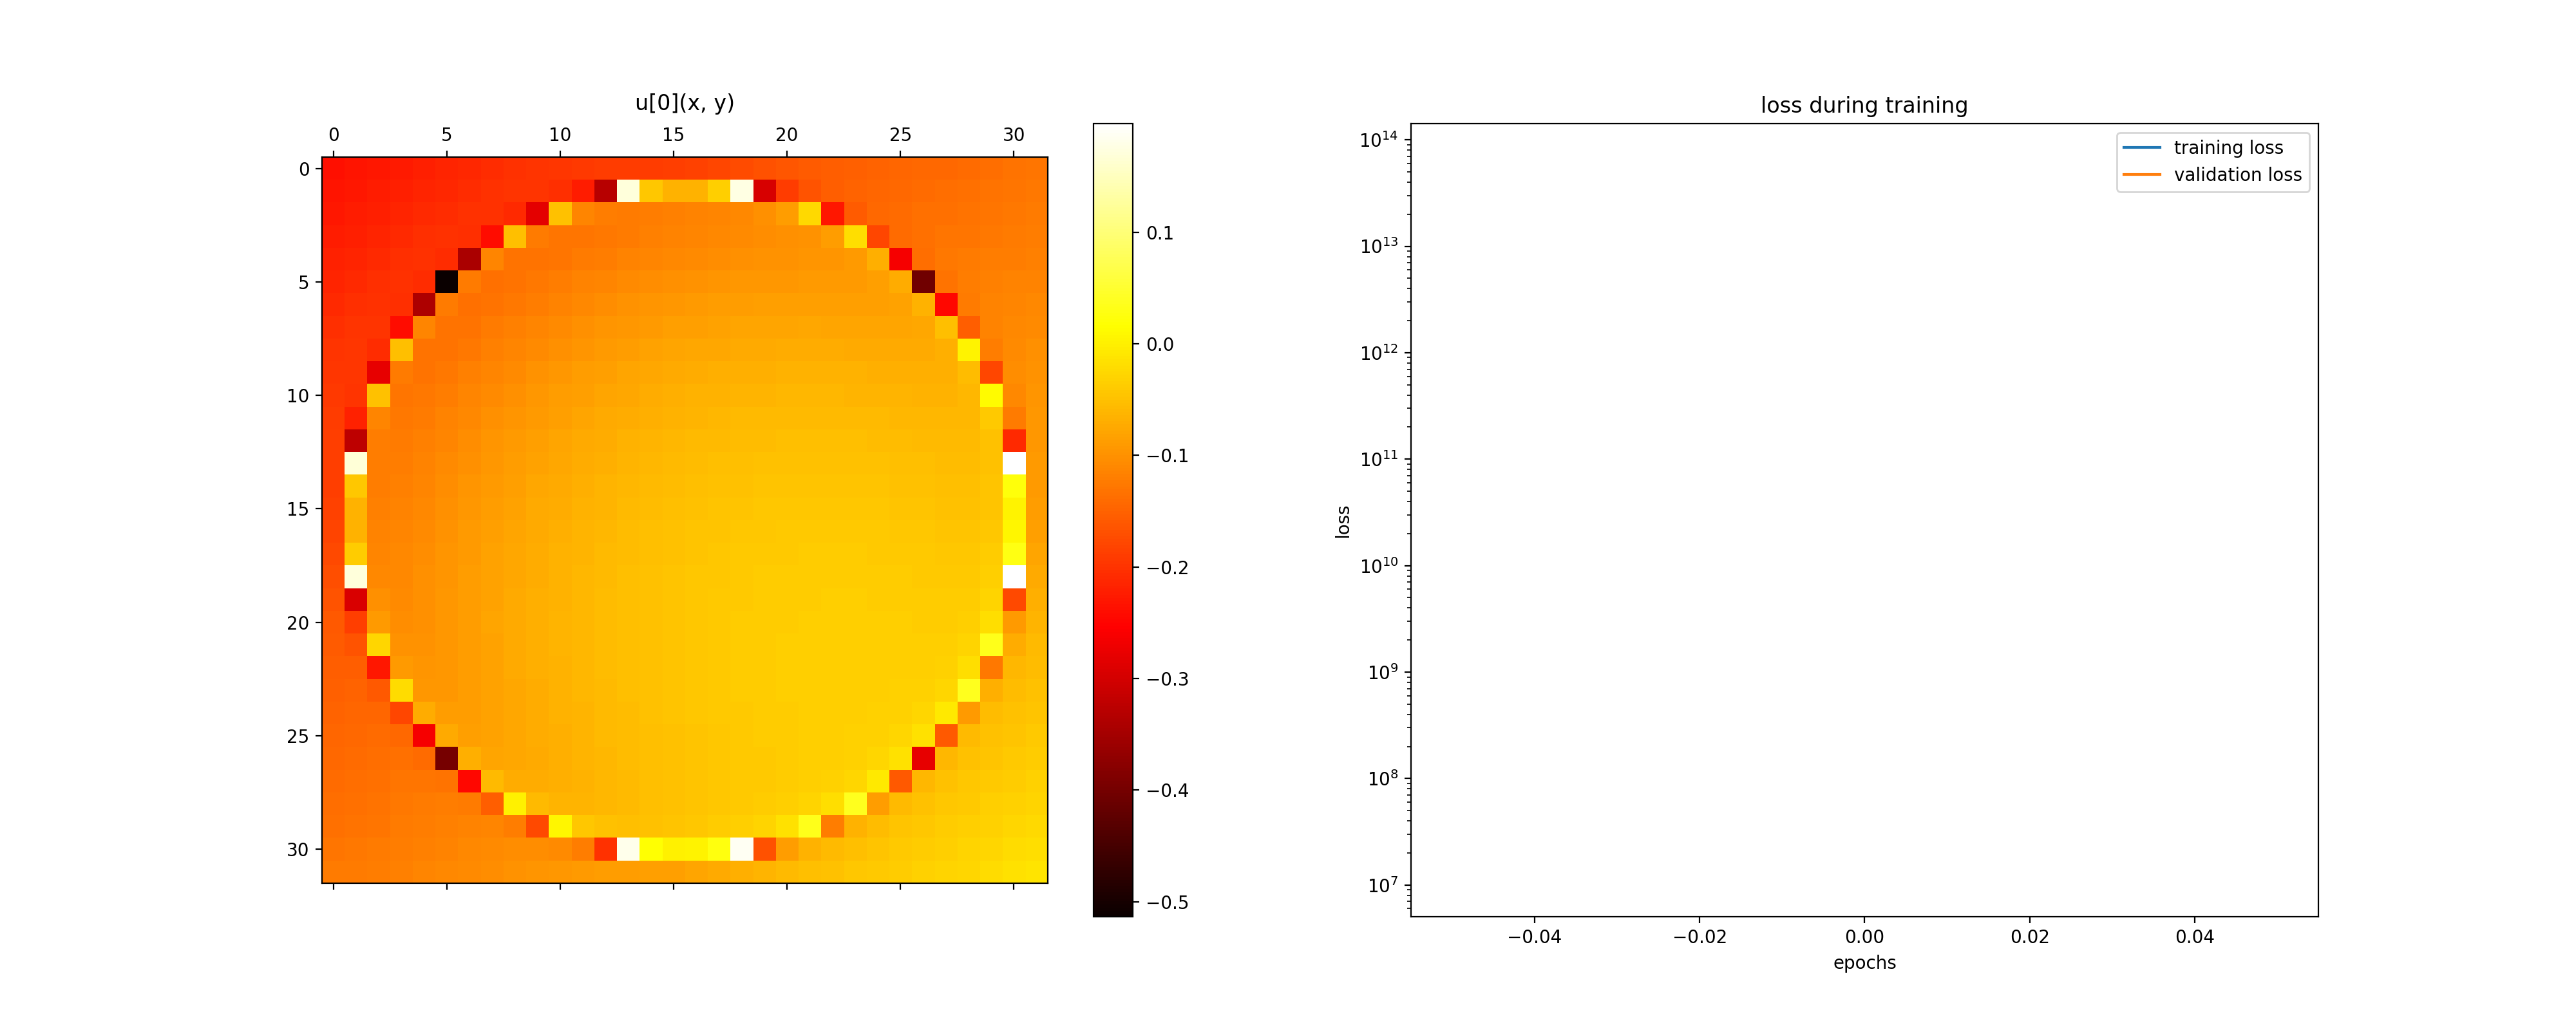

In [5]:
%matplotlib notebook
poisson = lambda u, x, y: diff(u, x, order=2) + diff(u, y, order=2) - 1
bc  = CircularNeumannHomogeneous(r=1, val=0.5)
net = FCNN(n_input_units=2, n_hidden_units=32, n_hidden_layers=1, actv=nn.Tanh)
adam = optim.Adam(params=net.parameters(), lr=1e-5)

solution_neural_net_poisson, _ = solve2D(
    pde=poisson, condition=bc, xy_min=(-1, -1), xy_max=(1, 1),
    net=net, optimizer=adam, max_epochs=10, train_generator=ExampleGenerator2D(
        (32, 32), (-1, -1), (1, 1), method='equally-spaced-noisy'
    ),
    monitor=Monitor2D(check_every=10, xy_min=(-1, -1), xy_max=(1, 1))
)

In [6]:
# boundary condition is satisfied
xs = np.linspace(-1, 1, 101, dtype=np.float32)
ys = np.sqrt(1.0-xs**2)
xs = torch.tensor(xs, requires_grad=True).reshape(-1, 1)
ys = torch.tensor(ys, requires_grad=True).reshape(-1, 1)

us = solution_neural_net_poisson(xs, ys)
nxgradu = xs * diff(us, xs) + ys * diff(us, ys)
print('The upper half of the boundary:\n', nxgradu[:10])

xs = np.linspace(-1, 1, 101, dtype=np.float32)
ys = -np.sqrt(1.0-xs**2)
xs = torch.tensor(xs, requires_grad=True).reshape(-1, 1)
ys = torch.tensor(ys, requires_grad=True).reshape(-1, 1)

us = solution_neural_net_poisson(xs, ys)
nxgradu = xs * diff(us, xs) + ys * diff(us, ys)
print('The lower half of the boundary:\n', nxgradu[:10])

The upper half of the boundary:
 tensor([[0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000]], grad_fn=<SliceBackward>)
The lower half of the boundary:
 tensor([[0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000]], grad_fn=<SliceBackward>)


In [7]:
xs, ys = torch.linspace(-1, 1, 101, requires_grad=True), torch.linspace(-1, 1, 101, requires_grad=True)
xx, yy = torch.meshgrid(xs, ys)
uu = solution_neural_net_poisson(xx, yy)

nx_nabla_u_net = xx * diff(uu, xx) + yy*diff(uu, yy)
nx_nabla_u_ana = 0.5 * (xx**2 + yy**2)

# for plotting
nx_nabla_u_net, nx_nabla_u_ana = nx_nabla_u_net.detach().numpy(), nx_nabla_u_ana.detach().numpy()
xx, yy = xx.detach().numpy(), yy.detach().numpy()

In [8]:
def compare_contour(sol_ana, sol_net, xx, yy):
    fig = plt.figure(figsize=(18, 4))

    ax1 = fig.add_subplot(131)
    cs1 = ax1.contourf(xx, yy, sol_net, cmap='coolwarm')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_aspect('equal', adjustable='box')
    ax1.set_title('ANN-based solution')
    cbar1 = fig.colorbar(cs1, format='%.0e', ax=ax1)

    ax2 = fig.add_subplot(132)
    cs2 = ax2.contourf(xx, yy, sol_ana, cmap='coolwarm')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_aspect('equal', adjustable='box')
    ax2.set_title('analytical solution')
    cbar2 = fig.colorbar(cs2, format='%.0e', ax=ax2)

    ax3 = fig.add_subplot(133)
    cs3 = ax3.contourf(xx, yy, sol_net-sol_ana, cmap='coolwarm')
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_aspect('equal', adjustable='box')
    ax3.set_title('residual of ANN-based solution')
    cbar3 = fig.colorbar(cs3, format='%.0e', ax=ax3)

<IPython.core.display.Javascript object>


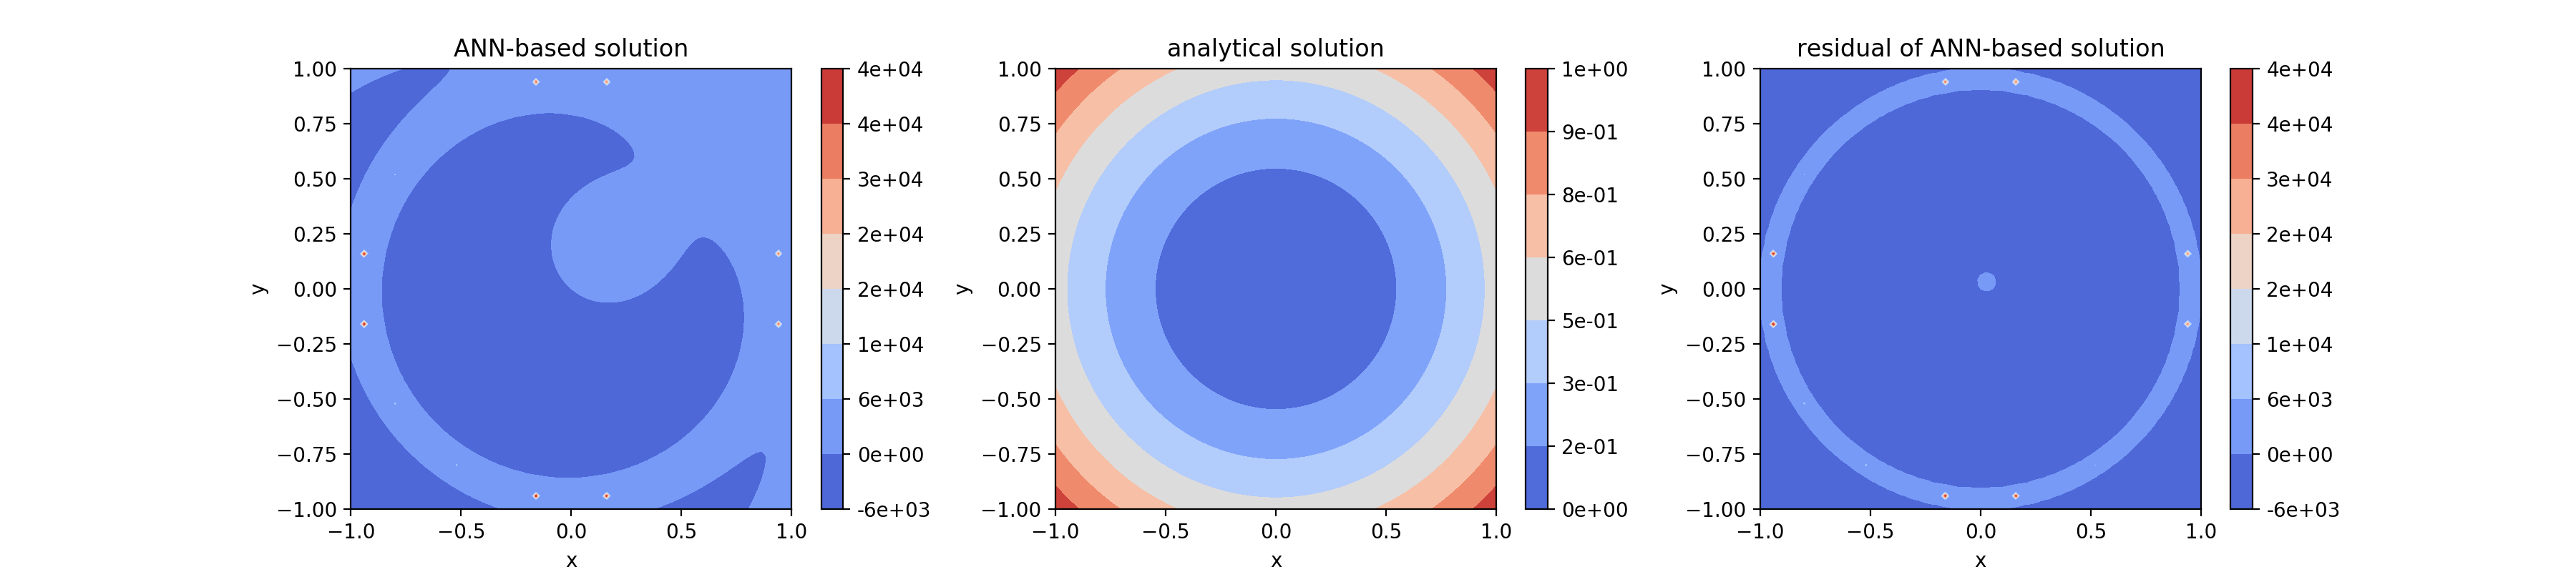

In [9]:
compare_contour(nx_nabla_u_ana, nx_nabla_u_net, xx, yy)

In [10]:
from mpl_toolkits.mplot3d  import Axes3D
def plt_surf(xx, yy, zz, z_label='u', x_label='x', y_label='y', title=''):
    fig  = plt.figure(figsize=(16, 8))
    ax   = Axes3D(fig)
    surf = ax.plot_surface(xx, yy, zz, rstride=2, cstride=1, alpha=0.8, cmap='hot')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    ax.set_title(title)
    ax.set_proj_type('ortho')
    plt.show()

<IPython.core.display.Javascript object>


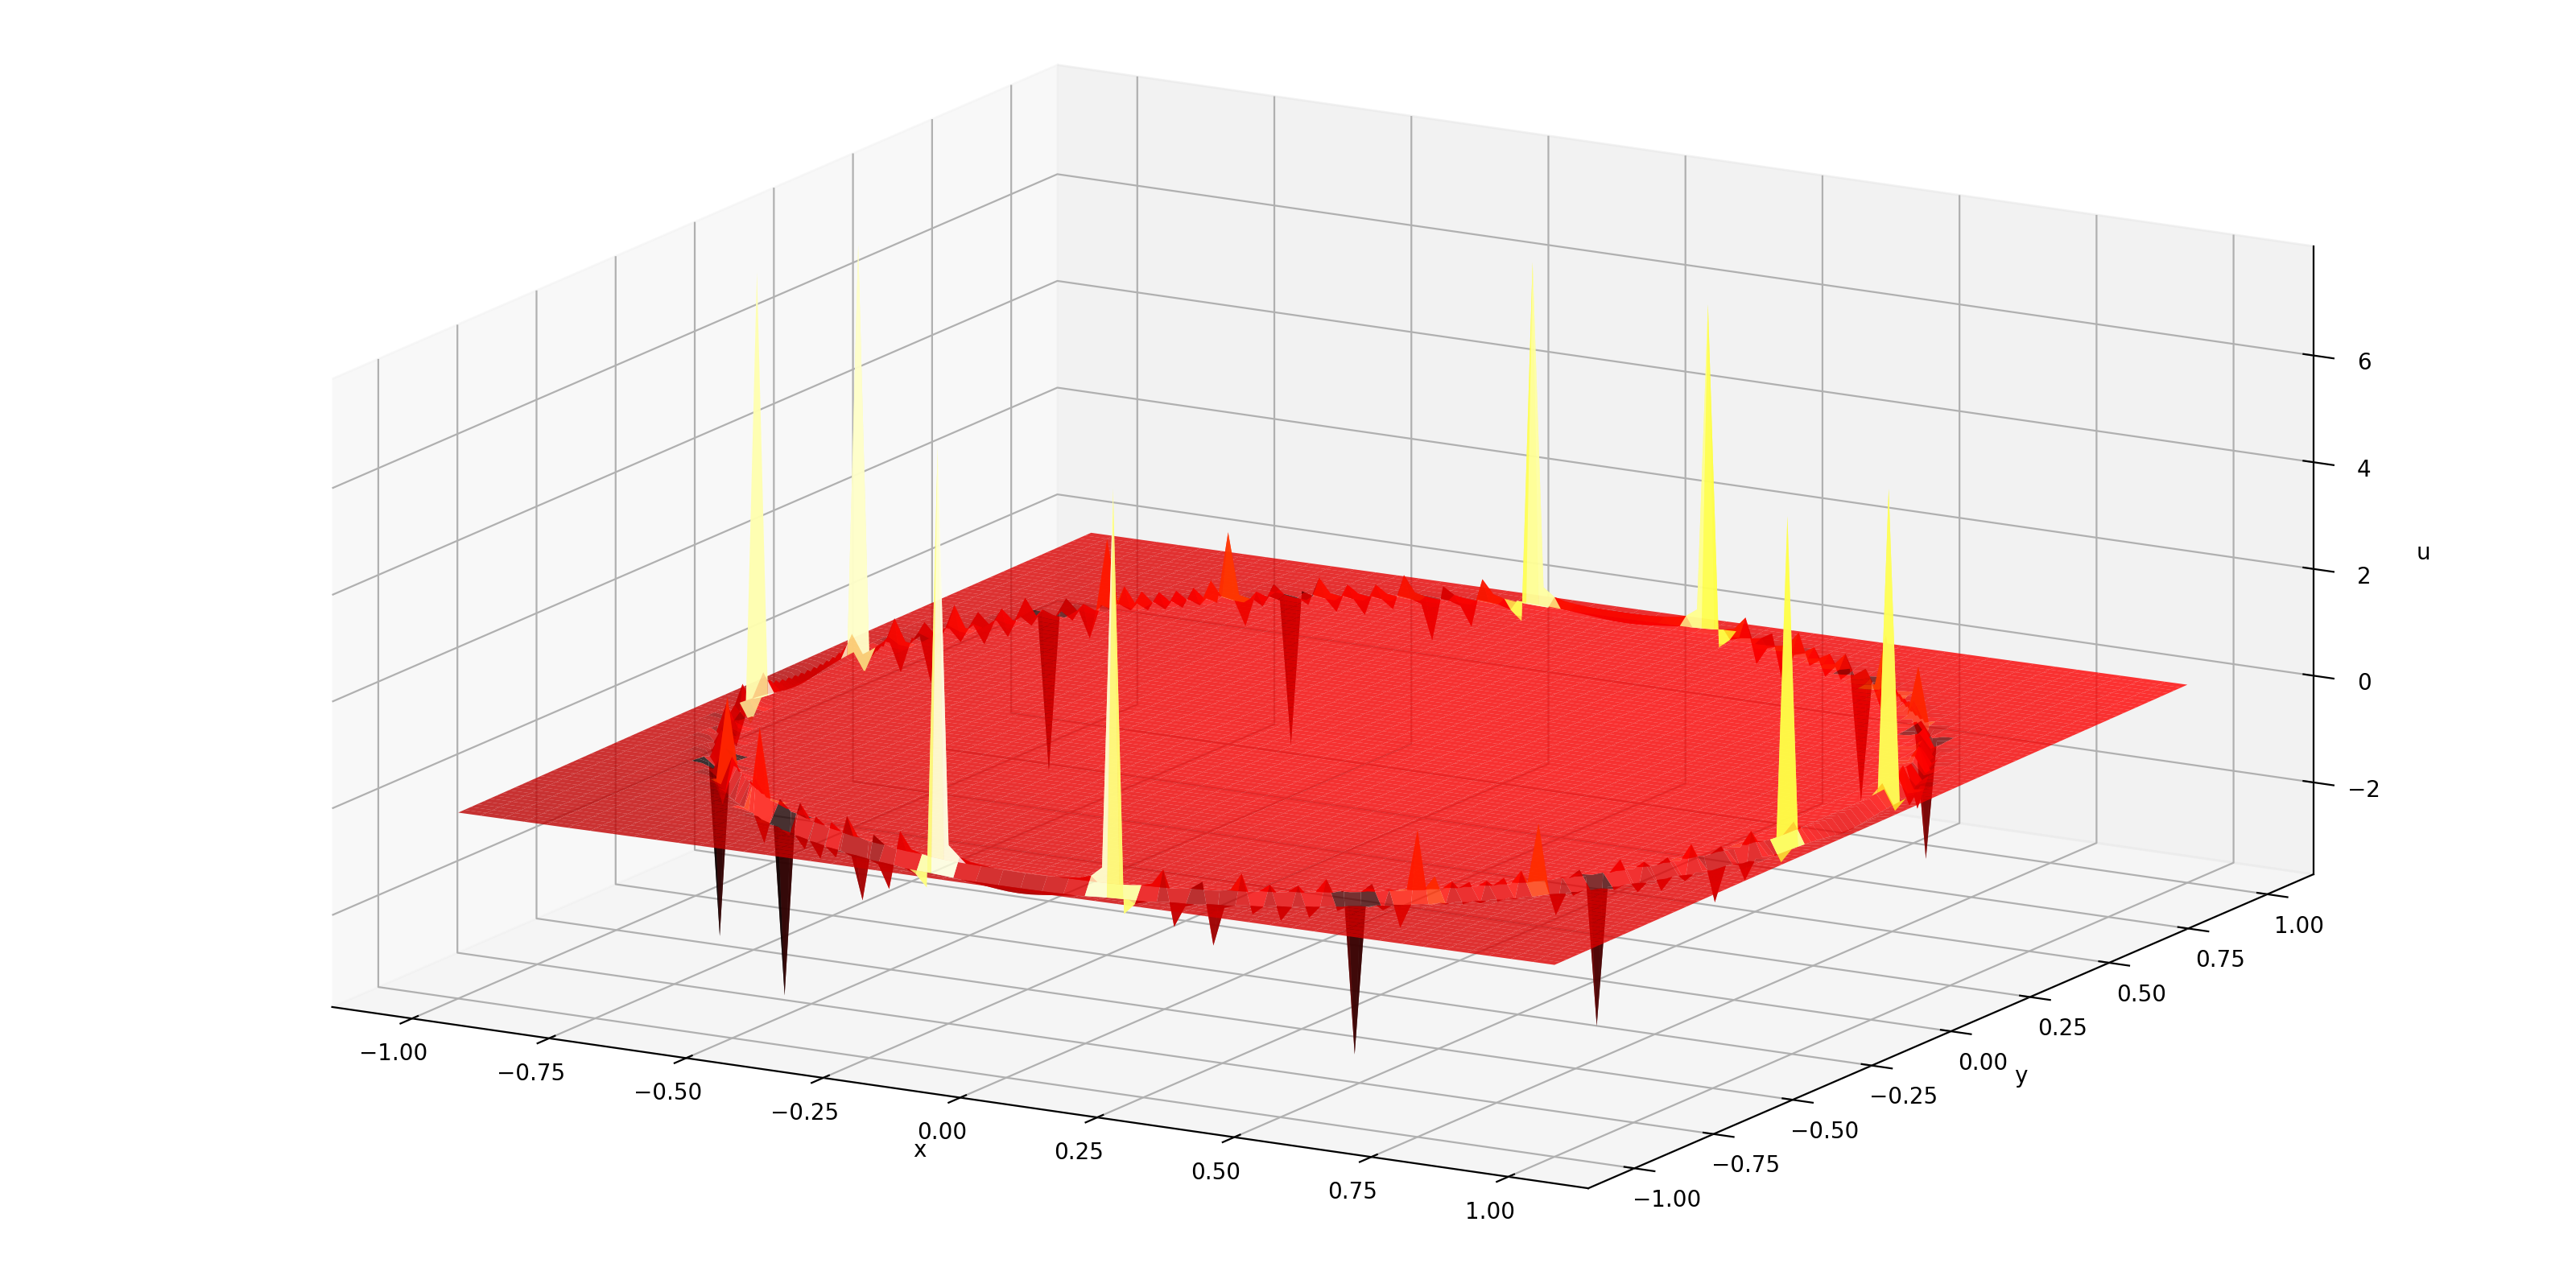

In [11]:
plt_surf(xx, yy, uu.detach().numpy())